# Sleep Data Analysis
Justin Yi  
4/22/25  
CPSC 222
Spring 2025
Description:  
This Jupyter Notebook explores, interprets, and learns my sleep data.

In [77]:
import utils
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import importlib
import datetime as dt

importlib.reload(utils)

<module 'utils' from 'd:\\School\\Spring 2025\\Intro to Data Science\\Data Assignments\\Project\\utils.py'>

## Overview
The two datasets we'll be combining and analyzing are my personal sleep data from my time here at GU, collected by Fitbit, and weather data of Spokane courtesty of MeteoStat API. This Notebook will walk you through my cleaning, EDA, and statistical analysis. Let's take a look at what we have:

In [78]:
sleep_df = pd.read_csv("sleep_score.csv")
weather_df = utils.get_spokane_weather_df()
weather_df.to_csv("initial_spokane_weather.csv")
print(sleep_df.head())
print(weather_df.head())

   sleep_log_entry_id             timestamp  overall_score  composition_score  \
0         48988871406  2025-04-16T06:58:30Z             76                NaN   
1         48977379538  2025-04-15T08:18:30Z             71                NaN   
2         48967692815  2025-04-14T09:27:30Z             84                NaN   
3         48959170544  2025-04-13T07:16:00Z             73                NaN   
4         48948016693  2025-04-12T05:12:30Z             70                NaN   

   revitalization_score  duration_score  deep_sleep_in_minutes  \
0                    76             NaN                   55.0   
1                    71             NaN                   59.0   
2                    84             NaN                  122.0   
3                    73             NaN                   79.0   
4                    70             NaN                   14.0   

   resting_heart_rate  restlessness  
0                  64      0.083240  
1                  65      0.093929  
2 

## Cleaning and Preparation
I'd like to join both DataFrames on their date columns to get a bigger, combined dataset, but there's some cleaning we need to do:
1. For sleep_df:
    * We can drop the sleep_log_entry_id column because they serve no predictive purpose and the dates already serve as unique keys
    * We should drop instances that occur before 2023-08-26 (my first move-in day)
    * We should remove the timestamps, keep the dates, and rename the "timestamp" column to "date"
    * For classification purposes, let's decode my overall sleep scores based on [Fitbit's calculation method](https://support.google.com/fitbit/answer/14236513?hl=en#zippy=%2Cwhats-my-fitbit-sleep-score%2Chow-is-my-sleep-score-calculated-in-the-fitbit-app)
        * 90-100: Excellent
        * 80-89: Good
        * 60-79: Fair
        * <60: Poor
1. For weather_df:
    * We can drop the "00:00:00" from every date because it's constant and we want consistency with sleep_df's date column
1. We should also drop completely empty columns in both DataFrames because interpolation is literally impossible with them and they serve no purpose
1. We should also interpolate missing values for both DataFrames. We should also use `ffill()` and `bbfill()`as a precaution for missing beginning and ending values.

In [79]:
# Cleaning sleep_df
#1 Dropping ID column
sleep_df = utils.drop_column(sleep_df, "sleep_log_entry_id")
#2 Drop undesired rows
sleep_df = utils.drop_rows_by_starting_index(sleep_df, 518, 743)
#3 Clean timestamps
sleep_df = utils.remove_string_ends(sleep_df, "timestamp", 10)
sleep_df.rename(columns={"timestamp": "date"}, inplace=True)
#4 Remove the empty columns
sleep_df = utils.drop_empty_columns(sleep_df)
#5 Address missing value on 2025-03-08; we'll interpolate
sleep_df = utils.fill_missing_values(sleep_df)
#6 Decode overall sleep score
sleep_df = utils.decode_sleep_scores(sleep_df)

sleep_df.to_csv("cleaned_sleep_score.csv")

d:\School\Spring 2025\Intro to Data Science\Data Assignments\Project\utils.py:39: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method="linear", inplace=True)


In [80]:
# Cleaning weather 
#1 Clean the date column
weather_df = utils.remove_string_ends(weather_df, "date", 10)
#2 Remove the empty columns
weather_df = utils.drop_empty_columns(weather_df)
#3 Fill empty data
weather_df = utils.fill_missing_values(weather_df)

weather_df.to_csv("cleaned_spokane_weather.csv")

d:\School\Spring 2025\Intro to Data Science\Data Assignments\Project\utils.py:39: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method="linear", inplace=True)


We can now perform an inner join of the two DataFrames on the "date" column.

In [81]:
# Joining both datasets
merged_df = sleep_df.merge(weather_df, on=["date"], how="inner")
merged_df.set_index("date", inplace=True)

There are a couple of other things I want to do before EDA:
1. Split up the Dataframe into semester groups
    * They will be used for hypothesis testing
    * Converting the indexes to datetime objects prevents splitting up by indices
1. Convert the "date" column to a datetime object and extract the day, month, and year columns.
    * This will allow us to plot without issues
    * It'll also allow us to compare the stats by year

In [82]:
# Semester groups
# Note: slice from soonest to latest because that's how the df is designed
fall_2023 = merged_df.loc["2023-12-12" : "2023-08-26"]
fall_2023.to_csv("Fall 2023.csv")
spring_2024 = merged_df.loc["2024-05-09" : "2024-01-14"]
spring_2024.to_csv("Spring 2024.csv")
fall_2024 = merged_df.loc["2024-12-12" : "2024-08-26"]
fall_2024.to_csv("Fall 2024.csv")
spring_2025 = merged_df.loc["2025-05-09" : "2025-01-14"]
spring_2025.to_csv("Spring 2025.csv")

In [83]:
# Pandas datetime object
merged_df = utils.create_datetime_columns(merged_df)
merged_df.to_csv("merged_df.csv")

The biggest challenge with cleaning was relearning and applying new techniques I haven't applied before.

## Exploratory Data Analysis
Now that our dataset is ready, we can begin exploring and understanding it. Let's get a general view of our features by using `pd.decribe` making line graphs:

In [84]:
# Overall Stats
merged_df.describe()

,year,month,day,revitalization_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,tavg,tmin,tmax,prcp,wdir,wspd,pres
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,2023.971042,6.617761,15.791506,74.696911,68.050193,62.739382,0.093808,48.886873,40.143436,58.351351,0.061331,162.926641,4.143822,1016.455598
std,0.616607,3.729312,8.897817,7.213438,24.807994,3.348783,0.025117,15.654284,12.770682,19.401310,0.127530,134.773344,3.020710,7.428155
min,2023.000000,1.000000,1.000000,43.000000,9.000000,54.000000,0.038314,-1.300000,-7.100000,5.000000,0.000000,0.000000,0.000000,996.300000
25%,2024.000000,3.000000,8.000000,70.000000,52.000000,60.000000,0.078351,37.400000,32.000000,42.325000,0.000000,15.000000,1.700000,1011.625000
50%,2024.000000,7.000000,16.000000,75.000000,68.000000,63.000000,0.091728,45.950000,37.900000,55.000000,0.000000,206.000000,3.400000,1015.300000
75%,2024.000000,10.000000,23.000000,80.000000,82.000000,65.000000,0.106183,60.375000,48.900000,73.900000,0.059000,283.000000,5.900000,1020.800000
max,2025.000000,12.000000,31.000000,91.000000,166.000000,74.000000,0.220697,87.300000,71.100000,106.000000,0.846000,360.000000,18.100000,1042.100000


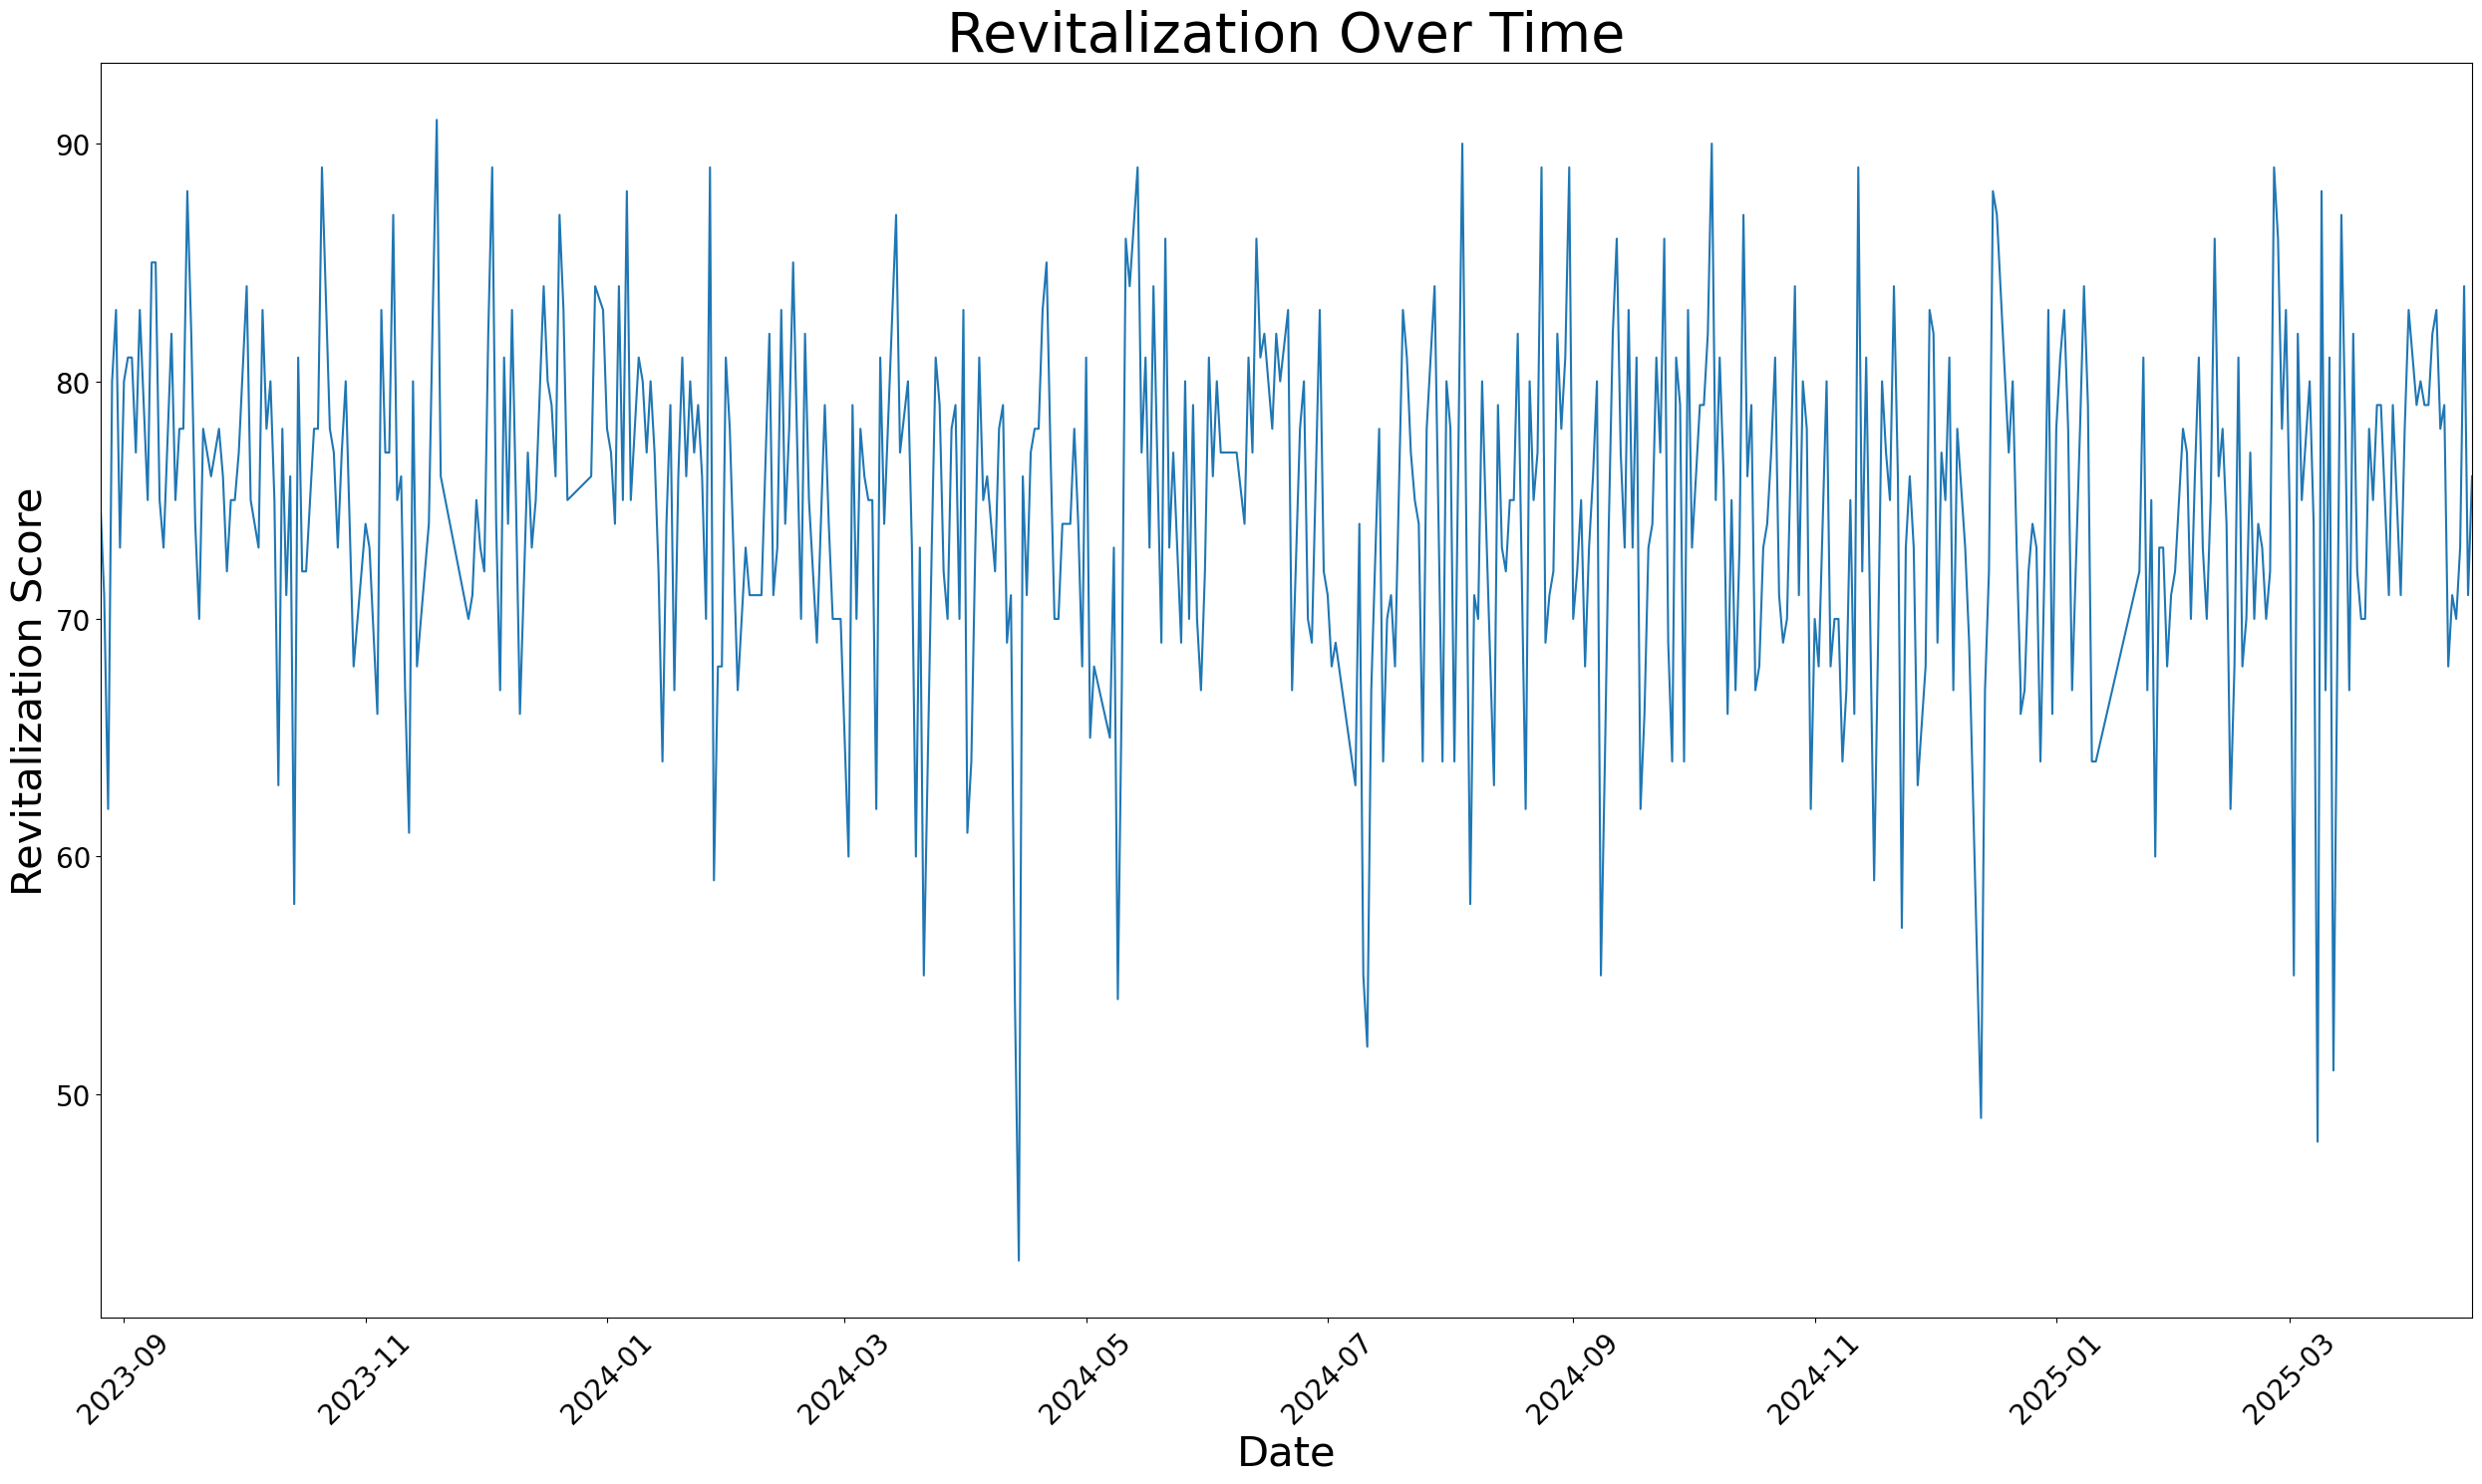

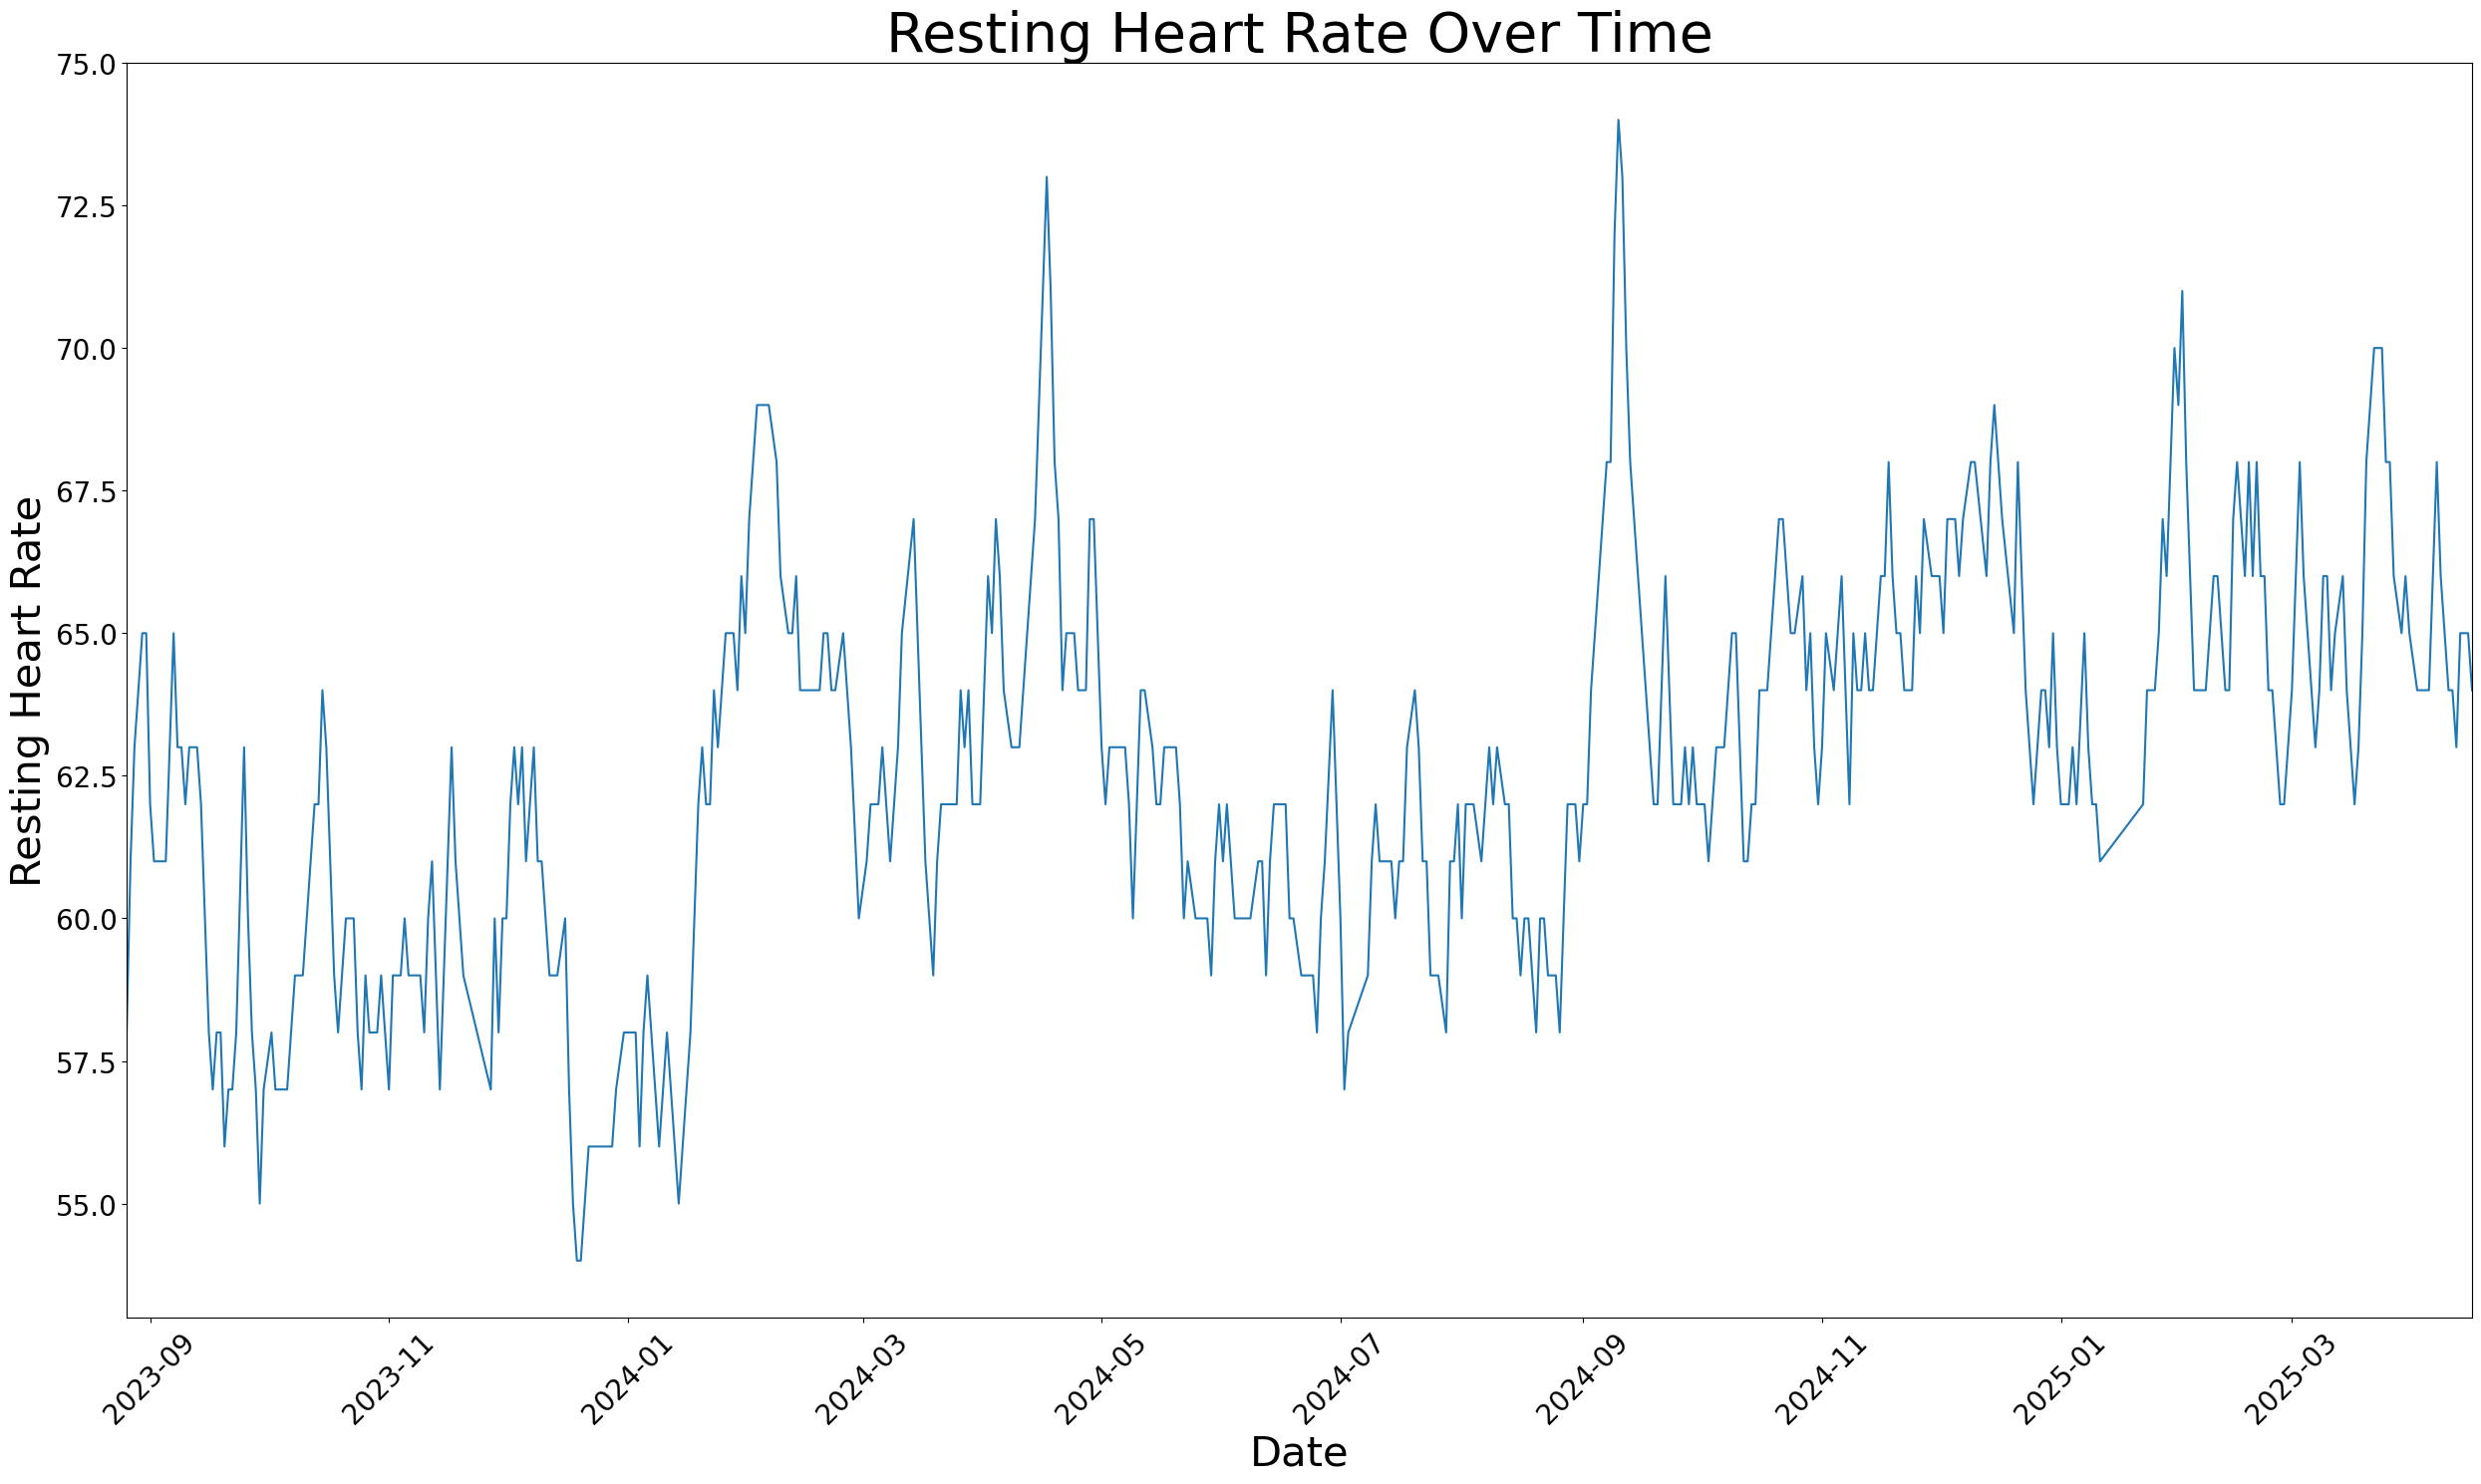

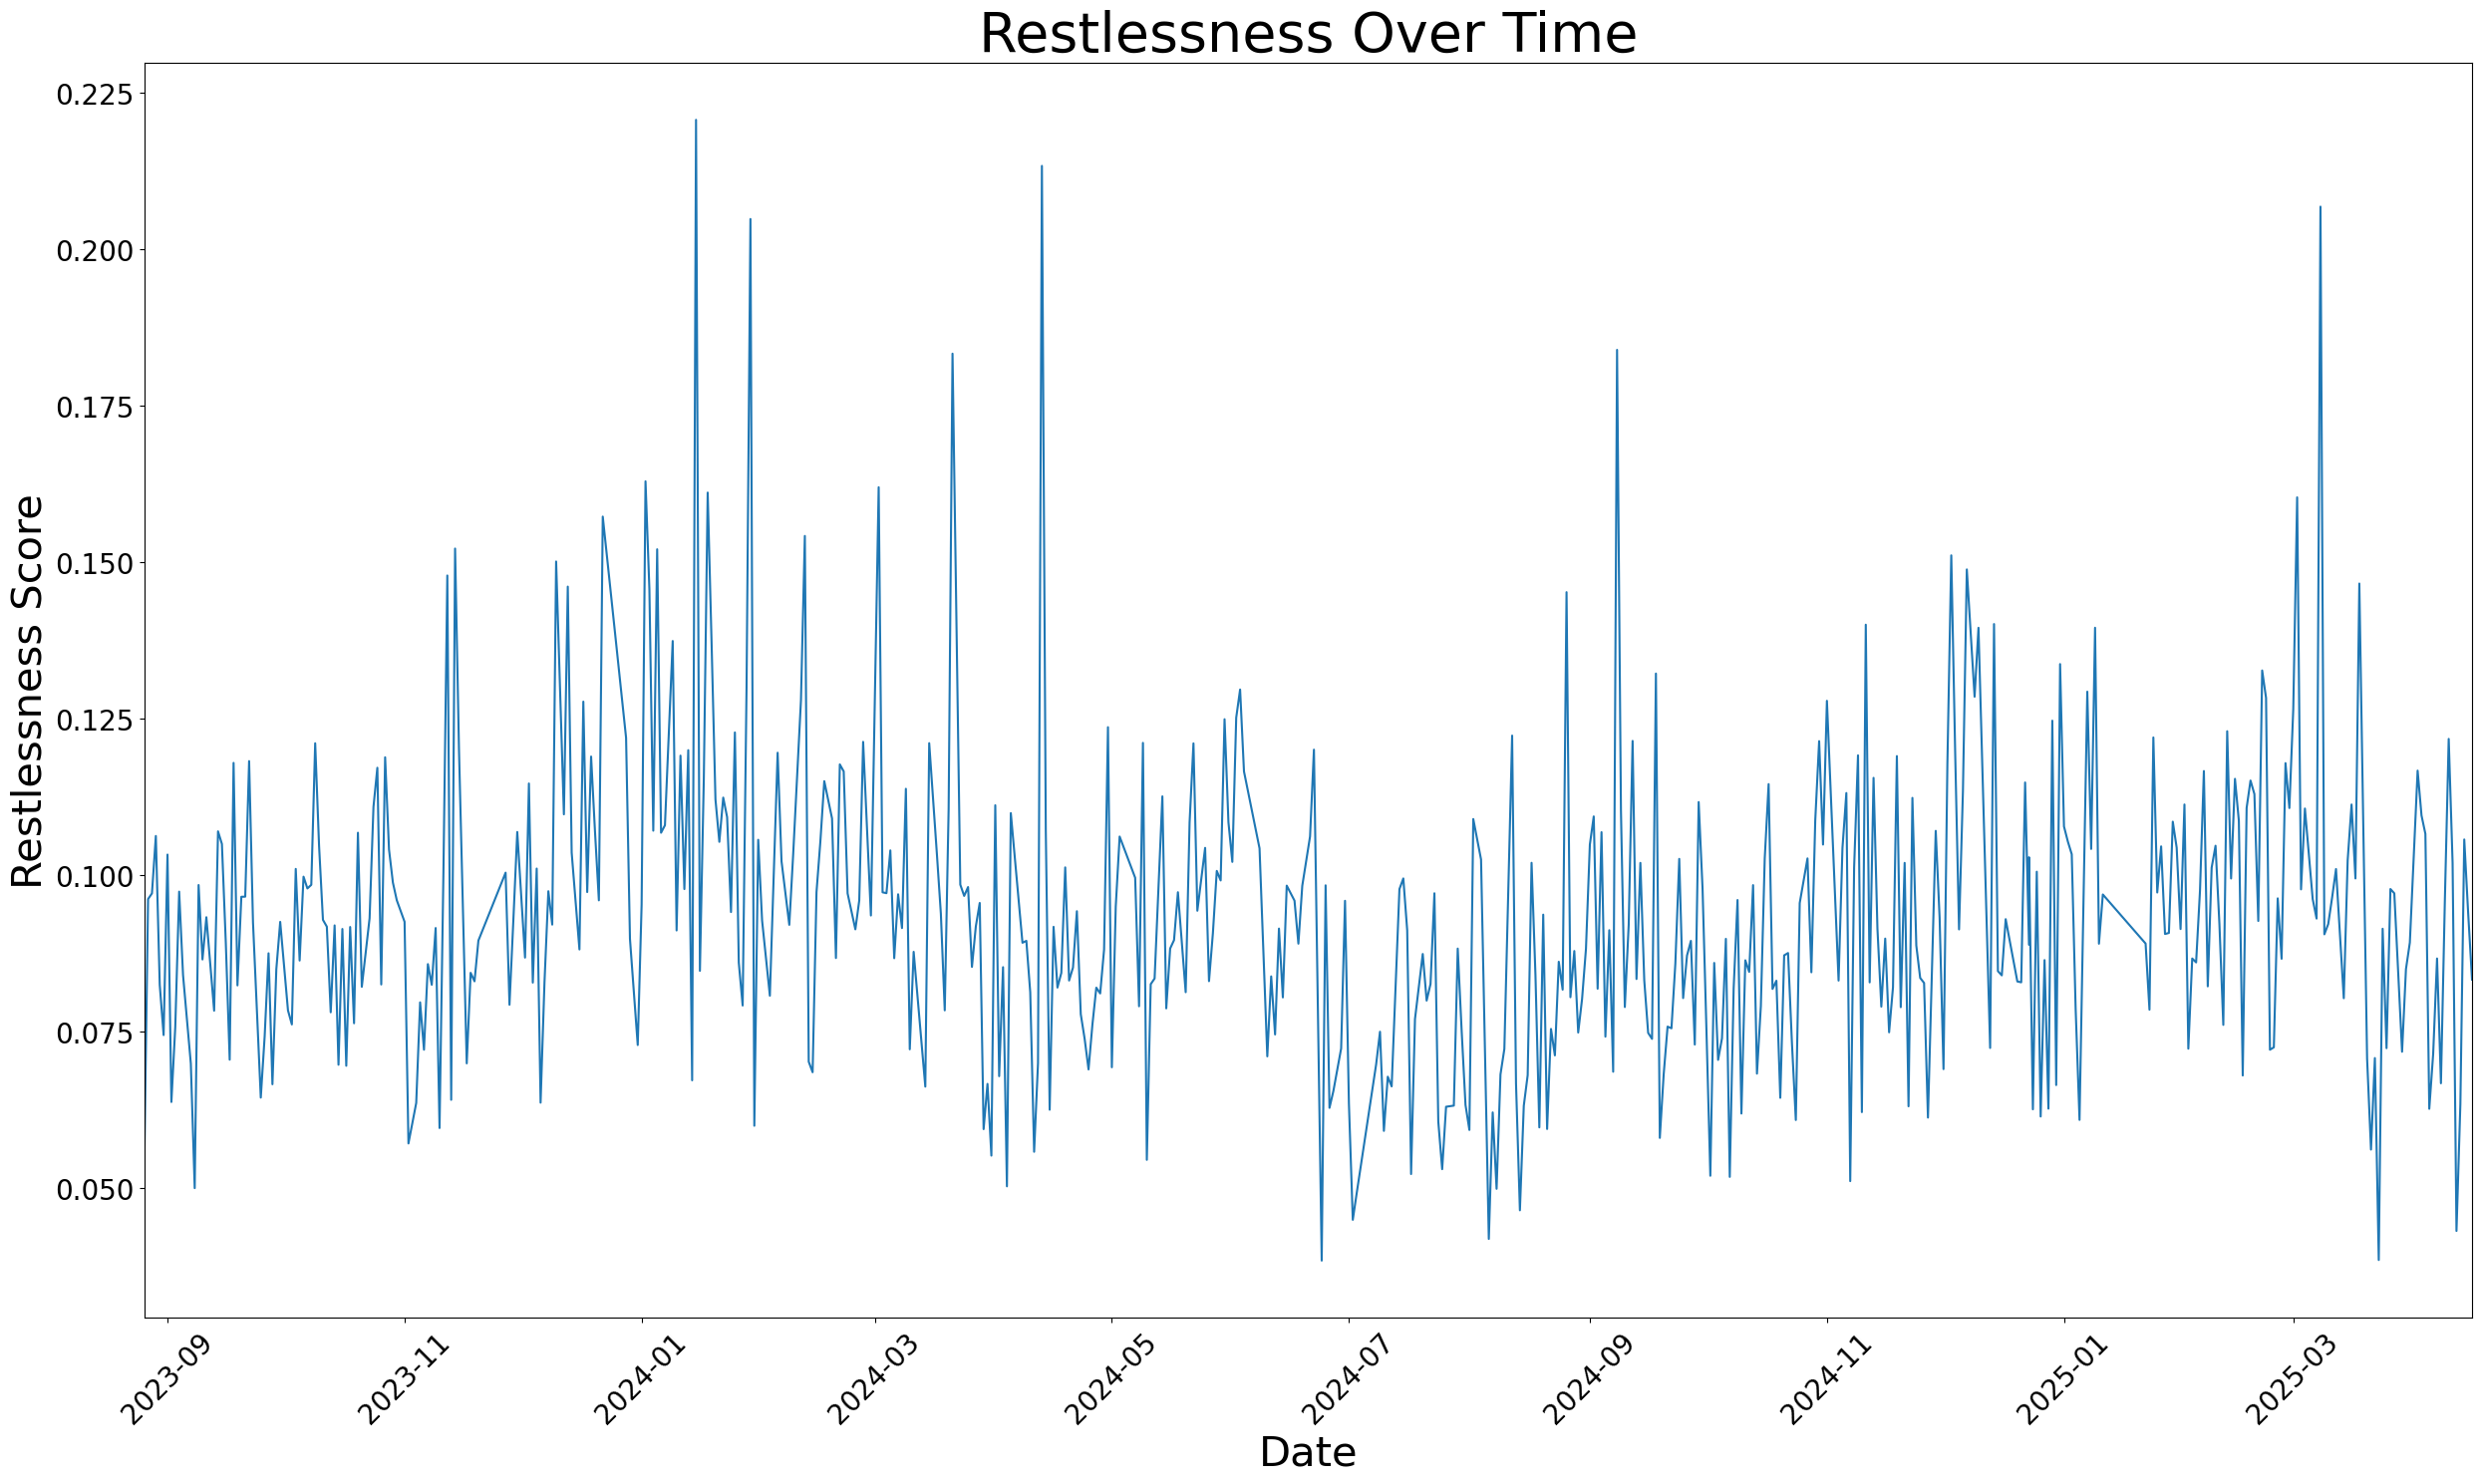

In [85]:
# Line graphs
utils.create_line_graph(merged_df.index, merged_df["revitalization_score"], "Revitalization Over Time", "Date", "Revitalization Score")
utils.create_line_graph(merged_df.index, merged_df["resting_heart_rate"], "Resting Heart Rate Over Time", "Date", "Resting Heart Rate")
utils.create_line_graph(merged_df.index, merged_df["restlessness"], "Restlessness Over Time", "Date", "Restlessness Score")

It is fascinating to see how my sleep patterns have behaved over time. Variations will occur, but sometimes changes will stay. We can easily see that my resting heart rate changed over time.

### Correlation Visualization
Let's take a closer look at the possible correlations between features. We can use a correlation matrix to get a clear view. We'll first need a DataFrame without the (string) class, but we might as well set up our feature matrix and target array.

In [86]:
# Create the two groups
y = merged_df.pop("overall_score")
X = merged_df

In [87]:
corr_df = X.corr()
corr_df.style.background_gradient(cmap="bwr")

,year,month,day,revitalization_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,tavg,tmin,tmax,prcp,wdir,wspd,pres
year,1.000000,-0.647460,-0.036357,-0.079384,-0.128249,0.525590,0.051973,-0.182671,-0.216316,-0.158812,-0.023860,0.046013,0.164241,0.016611
month,-0.647460,1.000000,-0.003106,0.014236,0.037276,-0.201282,-0.145965,0.266302,0.319833,0.224787,0.089929,0.046848,-0.115009,0.024502
day,-0.036357,-0.003106,1.000000,0.005885,0.031023,-0.036816,-0.061307,0.010736,0.020692,0.007297,-0.007686,0.009788,0.065415,0.010759
revitalization_score,-0.079384,0.014236,0.005885,1.000000,0.559395,-0.064691,-0.207760,-0.018798,-0.015562,-0.016143,-0.017600,-0.038087,0.017650,0.012489
deep_sleep_in_minutes,-0.128249,0.037276,0.031023,0.559395,1.000000,-0.110132,0.062724,-0.041689,-0.045011,-0.031427,-0.071556,-0.067715,-0.096968,0.057824
resting_heart_rate,0.525590,-0.201282,-0.036816,-0.064691,-0.110132,1.000000,-0.020519,-0.099280,-0.081691,-0.102124,0.042113,0.046793,0.087877,-0.011785
restlessness,0.051973,-0.145965,-0.061307,-0.207760,0.062724,-0.020519,1.000000,-0.309628,-0.291525,-0.309500,0.036070,-0.095311,-0.099235,0.101684
tavg,-0.182671,0.266302,0.010736,-0.018798,-0.041689,-0.099280,-0.309628,1.000000,0.957475,0.977479,-0.189369,0.092049,0.196480,-0.359028
tmin,-0.216316,0.319833,0.020692,-0.015562,-0.045011,-0.081691,-0.291525,0.957475,1.000000,0.886471,-0.074597,0.145324,0.261177,-0.416679
tmax,-0.158812,0.224787,0.007297,-0.016143,-0.031427,-0.102124,-0.309500,0.977479,0.886471,1.000000,-0.267635,0.026123,0.115025,-0.283788


It is somewhat funny that my heart rate decently correlates with the year becasue it did change each year. However, it is surprising that it doesn't correlate well with revitalization or deep sleep. We can also see that temperature has a notable inverse correlation with restlessness (as temperature increases, my restlessness decreases), which is somewhat surprising because I prefer sleeping in colder temperatures. Perhaps my body needs to warm up before it can rest?

### Hypothesis Testing


Let's perform some hypothesis tests to see how much my sleep patterns have changed over time.